# Exploring alternative solutions with $\epsilon$-perturbation sampling

CORNETO includes a basic **ε-Perturbation Sampling** method for uncovering near-optimal alternatives. Starting from the optimal solution, it applies small random “jitter” to a selected variable, re-solves the model, and retains only those samples whose original objectives remain within a user-specified tolerance. The result is a collection of feasible alternatives that highlights which components are fixed versus flexible.

We will illustrate this process using a simple example of a network inference problem with CARNIVAL, using the data from the [CARNIVAL transcriptomics tutorial](single-sample-carnival-transcriptomics.ipynb).

> NOTE: This notebook uses `gurobi` as the solver and `cvxpy` as the backend to accelerate the generation of alternative solutions using the `warm_start` option from cvxpy


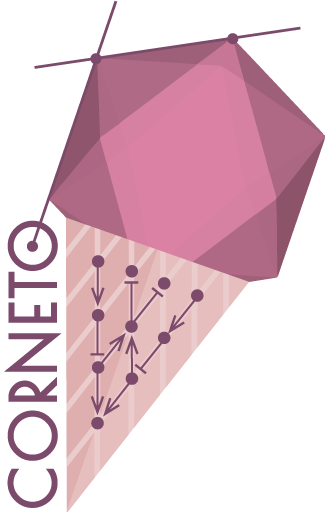

In [1]:
import corneto as cn
import numpy as np
import pandas as pd

cn.enable_logging()
cn.info()

In [2]:
# Load dataset from tutorial
dataset = cn.GraphData.load("data/carnival_transcriptomics_dataset.zip")

In [3]:
from corneto.methods.future import CarnivalFlow

m = CarnivalFlow(lambda_reg=0.1)
P = m.build(dataset.graph, dataset.data)
P.objectives

Unreachable vertices for sample: 0


[error_sample1_0: Expression(AFFINE, UNKNOWN, ()),
 regularization_edge_has_signal: Expression(AFFINE, NONNEGATIVE, ())]

In [4]:
# We will sample solutions by perturbing the edge_has_signal variable
P.expr

{'_flow': _flow: Variable((3374,), _flow),
 'edge_activates': edge_activates: Variable((3374, 1), edge_activates, boolean=True),
 'const0x144be068ae3d485b': const0x144be068ae3d485b: Constant(CONSTANT, NONNEGATIVE, (970, 3374)),
 '_dag_layer': _dag_layer: Variable((970, 1), _dag_layer),
 'edge_inhibits': edge_inhibits: Variable((3374, 1), edge_inhibits, boolean=True),
 'const0x4db7440b66998bb': const0x4db7440b66998bb: Constant(CONSTANT, NONNEGATIVE, (970, 3374)),
 'flow': _flow: Variable((3374,), _flow),
 'vertex_value': Expression(AFFINE, UNKNOWN, (970, 1)),
 'vertex_activated': Expression(AFFINE, NONNEGATIVE, (970, 1)),
 'vertex_inhibited': Expression(AFFINE, NONNEGATIVE, (970, 1)),
 'edge_value': Expression(AFFINE, UNKNOWN, (3374, 1)),
 'edge_has_signal': Expression(AFFINE, NONNEGATIVE, (3374, 1))}

In [5]:
# These are the original objectives of the problem
for o in P.objectives:
    print(o.name)

error_sample1_0
regularization_edge_has_signal


## Edge-Based Perturbation

First, we'll sample solutions by perturbing the edge variables. This allows us to explore
alternative network topologies where different edges might be selected.

In [6]:
from corneto.methods.sampler import sample_alternative_solutions

# Create a fresh model
m = CarnivalFlow(lambda_reg=0.1)
P = m.build(dataset.graph, dataset.data)

# NOTE: The sampler modifies the original P problem
results = sample_alternative_solutions(
    P,
    "edge_has_signal",
    percentage=0.10,
    scale=0.05,
    rel_opt_tol=0.10,
    max_samples=30,
    solver_kwargs=dict(
        solver="gurobi",
        max_seconds=300
    )
)

Unreachable vertices for sample: 0
Set parameter Username
Set parameter LicenseID to value 2593994
Academic license - for non-commercial use only - expires 2025-12-02


[INFO] corneto.methods.sampler: [1/30] accepted (total accepted=1) -> error_sample1_0: val=7.01697, rel.err=0.0000, regularization_edge_has_signal: val=94, rel.err=0.0217 (excluded from tol. check)
[INFO] corneto.methods.sampler: [2/30] accepted (total accepted=2) -> error_sample1_0: val=7.01697, rel.err=0.0000, regularization_edge_has_signal: val=93, rel.err=0.0109 (excluded from tol. check)
[INFO] corneto.methods.sampler: [3/30] accepted (total accepted=3) -> error_sample1_0: val=7.01697, rel.err=0.0000, regularization_edge_has_signal: val=93, rel.err=0.0109 (excluded from tol. check)
[INFO] corneto.methods.sampler: [4/30] accepted (total accepted=4) -> error_sample1_0: val=7.01697, rel.err=0.0000, regularization_edge_has_signal: val=94, rel.err=0.0217 (excluded from tol. check)
[INFO] corneto.methods.sampler: [5/30] accepted (total accepted=5) -> error_sample1_0: val=7.01697, rel.err=0.0000, regularization_edge_has_signal: val=96, rel.err=0.0435 (excluded from tol. check)
[INFO] cor

In [7]:
edges = np.squeeze(results['edge_value']).T
df_sols = pd.DataFrame(edges, index=m.processed_graph.E).astype(int)
print(f"Generated {df_sols.shape[1]} alternative solutions")
df_sols.head()

Generated 31 alternative solutions


,,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
(SMAD3),(MYOD1),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(GRK2),(BDKRB2),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(MAPK14),(MAPKAPK2),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(DEPTOR_EEF1A1_MLST8_MTOR_PRR5_RICTOR),(FBXW8),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(SLK),(MAP3K5),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Analyze variability in edge selection
df_var = pd.concat([df_sols.mean(axis=1), df_sols.std(axis=1)], axis=1)
df_var.columns = ["mean", "std"]
print("Edges with highest variability across solutions:")
df_var.sort_values(by="std", ascending=False).head(50).sort_values(by="mean")

Edges with highest variability across solutions:


,,mean,std
(MAPK14),(GSK3B),-0.741935,0.444803
(PPP2CA),(PRKCD),-0.709677,0.461414
(JUN),(SPI1),-0.709677,0.461414
(GSK3B),(CEBPA),-0.709677,0.461414
(TGFB1),(PPP2R2A),-0.677419,0.475191
(CSNK1D),(WWTR1),-0.677419,0.475191
(),(TGFB1),-0.677419,0.475191
(SMAD3),(NKX2-1),-0.645161,0.486373
(PHLPP1),(PRKCA),-0.580645,0.501610
(NFKB1_RELA),(EGR1),-0.548387,0.505879


## Vertex-Based Perturbation

We can do the same but perturbing the vertices instead of the edges. This approach can highlight alternative sets of vertices that are consistent with the data.

In [9]:
# Create a fresh model
m = CarnivalFlow(lambda_reg=0.1)
P = m.build(dataset.graph, dataset.data)

# Sample solutions by perturbing vertex_value
results = sample_alternative_solutions(
    P,
    "vertex_value",
    percentage=0.10,
    scale=0.05,
    rel_opt_tol=0.10,
    max_samples=30,
    solver_kwargs=dict(
        solver="gurobi",
        max_seconds=300
    )
)

Unreachable vertices for sample: 0


[INFO] corneto.methods.sampler: [1/30] accepted (total accepted=1) -> error_sample1_0: val=7.01697, rel.err=0.0000, regularization_edge_has_signal: val=96, rel.err=0.0435 (excluded from tol. check)
[INFO] corneto.methods.sampler: [2/30] accepted (total accepted=2) -> error_sample1_0: val=7.01697, rel.err=0.0000, regularization_edge_has_signal: val=92, rel.err=0.0000 (excluded from tol. check)
[INFO] corneto.methods.sampler: [3/30] accepted (total accepted=3) -> error_sample1_0: val=7.01697, rel.err=0.0000, regularization_edge_has_signal: val=93, rel.err=0.0109 (excluded from tol. check)
[INFO] corneto.methods.sampler: [4/30] accepted (total accepted=4) -> error_sample1_0: val=7.01697, rel.err=0.0000, regularization_edge_has_signal: val=93, rel.err=0.0109 (excluded from tol. check)
[INFO] corneto.methods.sampler: [5/30] accepted (total accepted=5) -> error_sample1_0: val=7.01697, rel.err=0.0000, regularization_edge_has_signal: val=93, rel.err=0.0109 (excluded from tol. check)
[INFO] cor

In [10]:
vertex_values = np.squeeze(results["vertex_value"]).T
vertex_values.shape

(970, 31)

In [11]:
# Analyze vertex-based results
df_vertex_val = pd.DataFrame(vertex_values, index=m.processed_graph.V).astype(int)
print(f"Generated {df_vertex_val.shape[1]} alternative solutions")
df_vertex_val.head()

Generated 31 alternative solutions


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
FOS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RBL2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CAMKK1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PCBP2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
MAPKAPK2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Focus on signaling proteins with no measurement data
df_sig_prot_pred = df_vertex_val.loc[
    df_vertex_val.index.difference(dataset.data.query.pluck_features())
]
df_sig_prot_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
AAK1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABI1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABL1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
ABL2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABRAXAS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


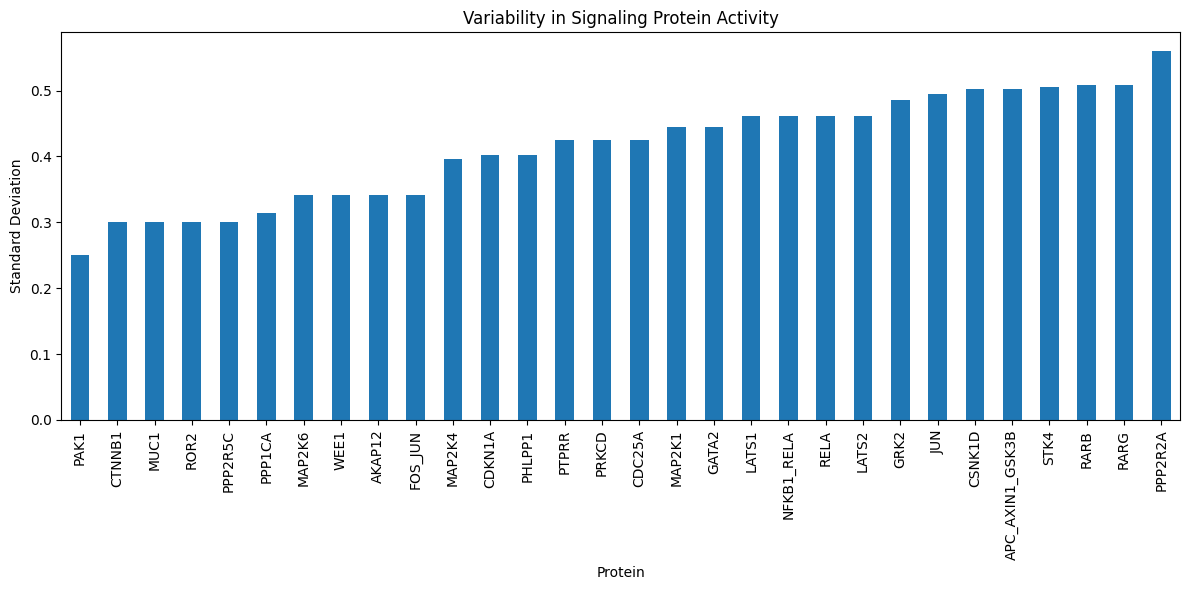

In [13]:
# Visualize the variability in predicted signaling protein activities
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_sig_prot_pred.std(axis=1).sort_values().tail(30).plot.bar(
    title="Variability in Signaling Protein Activity"
)
plt.xlabel("Protein")
plt.ylabel("Standard Deviation")
plt.tight_layout()
plt.show()